<a href="https://colab.research.google.com/github/titusss/Collective-Dreams_Fluid-Interfaces/blob/master/Collective_Dream_Analysis_BERTopic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fluid Interfaces** - 🛌🏾 Collective Dream Clustering and Path Finding

(last updated 16. January 2022 by Titus)

This is the *official* google colab notebook for topical clustering of dreams with BERTopic, dimensionality reduction through UMAP and low-dimension clustering with HDBSCAN, and path finding between dreams.

This notebook does not include generating videos from multiple dreams.


## BERTopic
*BERTopic is a topic modeling technique that leverages 🤗 transformers and a custom class-based TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.*

---
# **Table of contents**
1.   [Setup](#section-1)
2.   [Semantic Dream Clustering](#section-1)
3.   [Visualizing clustering results](#section-1)
4.   [Path Finding between Dreams](#section-1)
---

# Enabling the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

[Reference](https://colab.research.google.com/notebooks/gpu.ipynb)

---
<a name="section-1"></a>
# Section 1 ⚙️
# **Setup**

## **Installing BERTopic**

We start by installing BERTopic from PyPi:

In [1]:
%%capture
!pip install bertopic

## **Restart the Notebook!**
After installing BERTopic, some packages that were already loaded were updated and in order to correctly use them, we should now restart the notebook.

From the Menu:

Runtime → Restart Runtime

## **Loading dream dataset**
We need to load the dreams dataset from your google drive. To get access to your gdrive files, we first mount it. Please authorize this notebook to access your drive when prompted to do so.

In [ ]:
from google.colab import drive

drive.mount('content', force_remount=True) # Force remount to refresh when already mounted

Mounted at content


Set path to dream dataset in google cloud drive. Upload the desired .xlsc (Excel) file to your google drive. Find that file by clicking on the folder icon in the bar to your left. Click on the three vertical dots that appear when hovering over the desired file, and select "Copy path". Paste that path below.

**Note** You can download the dream dataset I used here: https://docs.google.com/spreadsheets/d/1y9bgrbYBdeA5DlOdH7oYmnXBTE0ITVNY/edit?usp=sharing&ouid=113415332448078740802&rtpof=true&sd=true

In [ ]:
path = '/content/content/MyDrive/dream_dataset.xlsx'

In [ ]:
!pip install pandas
import pandas as pd

In [ ]:
df = pd.read_excel(path, header=0)
print(df)

                                       Dream Description  ... What is your nationality?
0      “A Seaworthy Vessel” I have built a big raft f...  ...                       NaN
1      “A. Street” I’m back on A. Street, which is a ...  ...                       NaN
2      “Adventures” I take a taxi to my lover’s apart...  ...                       NaN
3      “Alien Lover” In this dream I find a dish unde...  ...                       NaN
4      “Angry Mob” All I remember is standing by feel...  ...                       NaN
...                                                  ...  ...                       ...
17152                                                NaN  ...                       NaN
17153                                                NaN  ...                       NaN
17154                                                NaN  ...                       NaN
17155                                                NaN  ...                       NaN
17156                           

## **Data Cleanup**
We're removing commong english words that mess with our clustering as well as replacing or removing the ' character.

In [ ]:
most_common_words = ["the", "be", "to", "of", "and", "a", "in", "that", "have", "i", "it", "for", "not", "on", "with", "he", "as", "you", "do", "at", "this", "but", "his", "by", "from", "they", "we", "say", "her", "she", "or", "an", "will", "my", "one", "all", "would", "there", "their", "what", "so", "up", "out", "if", "about", "who", "get", "which", "go", "me", "when", "make", "can", "like", "time", "no", "just", "him", "know", "take", "people", "into", "year", "your", "good", "some", "could", "them", "see", "other", "than", "then", "now", "look", "only", "come", "its", "over", "think", "also", "back", "after", "use", "two", "how", "our", "work", "first", "well", "way", "even", "new", "want", "because", "any", "these", "give", "day", "most", "us", "is", "im", "are", "its", "theres", "dont", "hes", "shes", "has", "theyre", "going", "was", "were", "had", "am"]

# Remove NaN from dream description
df_noempty = df[df['Dream Description'].notna()]

df_cleaned = pd.DataFrame(df_noempty['Dream Description'].str.replace(r"'", "")) # Remove all ' characters
df_cleaned = pd.DataFrame(df_cleaned['Dream Description'].str.replace(r"’", "")) # Remove all ’ characters
df_cleaned['Dream Description'] = df_cleaned['Dream Description'].astype(str) # Cast to string
df_cleaned['Dream Description'] = [' '.join([y for y in x.split() if y.lower() not in most_common_words]) for x in df_cleaned['Dream Description']]

docs = df_cleaned['Dream Description'].values
print("Cleaned dataset: ", docs)
print("Original dataset: ", df_noempty)

Cleaned dataset:  ['“A Seaworthy Vessel” built big raft ocean group 5. vessels been crafted used ocean, possibly race competition. having lunch wealthy well-connected couple. waiting son meet. really hit off. arrives immediate attraction between us. attraction flirtatious easy wonderful sense finding somebody very physical soulful connection. looking forward seeing each again evening before leave next day. sense urgency depth, along loss. leave lunch shopping clothes mom. very busy, mall store, young women sorting through clothes. distracted, goes along laundry hamper style basket fills different clothes, huge variety. While perusing through clothes, couple young women recieve devices restaurant light buzz table ready. changing rooms back. while, return devices, waiting too long needed go. somehow slip changing room front bunch clothes arms. mom brings basket clothes, pushing under door. different styles try on. great love all. surprised this. son outside waiting her. bottom basket stu

---
<a name="section-2"></a>
# Section 2 ☁️
# **Semantic Dream Clustering**
Here we're using the previously loaded data, and try to find semantic relationships.

## **BERT Topic Clustering**
Using the BERT deep learning transformer to spatially align the dreams based on topics.

Choose which pre-trained model BERT should use. Click [here](https://www.sbert.net/docs/pretrained_models.html) for a list of supported sentence transformers models.  

In [ ]:
model = 'all-roberta-large-v1'

\Load the BERT transformer with the pre-trained model defined above and cluster the data. This may take a few minutes but can be optimized by 1.) pre-loading the model, 2.) choosing a faster model from the link above, or 3.) choosing a smaller model.

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer(model)
embeddings = model.encode(docs, show_progress_bar=True)

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/328 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/191 [00:00<?, ?B/s]

Batches:   0%|          | 0/89 [00:00<?, ?it/s]

## **Dimensionality Reduction and visual clustering**
We use UMAP (t-sne alternative) to bring the clustered space from over 1,000 dimensions to just 3 or 2 and then categorizing the resulting, low-dimensional data cloud with HDBSCAN (this gives us the color in the final cloud).

In [ ]:
!pip install umap-learn

## **UMAP and HDBSCAN Parameters**

Play around with these settings and see how they influence the outcome.
See: https://umap-learn.readthedocs.io/en/latest/parameters.html for a nice description of what the parameters do for UMAP.

In [ ]:
dimensions = 3 # Enter the amount of dimensions. In theory, there's nothing wrong with using more than 3 dimensions even for a 2D visualization
neighbors = 50 # UMAP stuff
min_cluster = 5 # The minimum amount of dreams in a potential cluster to make it a cluster

In [ ]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=neighbors, 
                            n_components=dimensions, 
                            metric='cosine').fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

## **Calculate UMAP data**

In [ ]:
# Prepare data
result = pd.DataFrame(umap_embeddings, columns=['x', 'y', 'z'])
result['labels'] = cluster.labels_

2819
2819


Set dreams in result dict

In [ ]:
result['dreams'] = df_noempty['Dream Description'].values
result['dreams_shortened'] = docs

0       “A Seaworthy Vessel” I have built a big raft f...
1       “A. Street” I’m back on A. Street, which is a ...
2       “Adventures” I take a taxi to my lover’s apart...
3       “Alien Lover” In this dream I find a dish unde...
4       “Angry Mob” All I remember is standing by feel...
                              ...                        
2814    Zombie apocalypse, running, trying to prepare ...
2815    Zombie fighting dreams... but since the pandem...
2816    Zombie movies led to me being chased by zombie...
2817                               Zombie movies survival
2818    Zombies, post apocalyptic, outer space. Variou...
Name: dreams, Length: 2819, dtype: object
0       “A Seaworthy Vessel” built big raft ocean grou...
1       “A. Street” A. Street, street bought house Oma...
2       “Adventures” taxi lovers apartment. arrive doi...
3       “Alien Lover” dream find dish underneath chair...
4       “Angry Mob” remember standing feeling helpless...
                              

Print UMAP

In [ ]:
topics = pd.unique(cluster.labels_).tolist()
topics.sort()
print("Amount of topics: ", len(topics))
print("Topic IDs: ", topics)

Amount of topics:  77
Topic IDs:  [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]


---
<a name="section-3"></a>
# Section 3 🖼️
# **Visualizing clustering results**
The big reveal. Here we're plotting the results of our clustering from BERTopic -> UMAP -> HDBSCAN. What you'll see are 2D and 3D scatterplot in which every point represents a dream entry. The closer data points are to each other, the closer they should be semantically.

## **Matplot Lib 2D Scatterplot**
A simple 2D plot. Here we're greying-out outliers. Outliers are data entries which are considered too unique to be part of a cluster. We're not excluding outliers in the following visualizations, however.

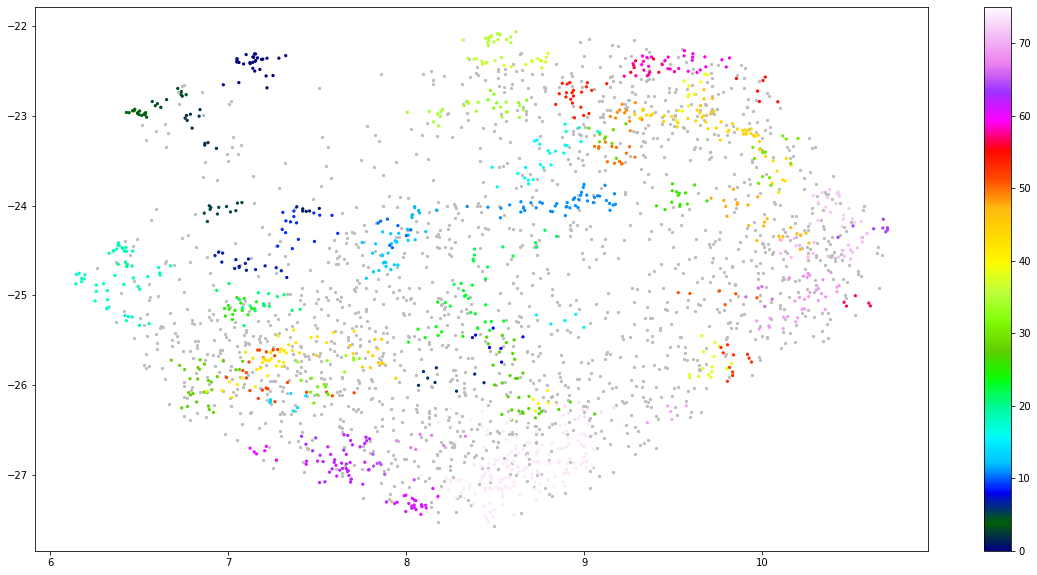

In [ ]:
import matplotlib.pyplot as plt

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=5)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=5, cmap='gist_ncar')
plt.colorbar()

## **2D and 3D interactive visualization in Plotly**
Visualize the same as above in 3D in plotly, including outliers.

In [ ]:
# Note: 'Clustered' only has non outliers in it! Use 'result' for everything.
#!pip install plotly
import plotly.express as px

fig_2d = px.scatter(
    clustered, x=clustered.x, y=clustered.y,
    color=clustered.labels, color_continuous_scale='mygbm', labels={'color': 'Dream Topics'}, hover_data=['dreams']
)
fig_3d = px.scatter_3d(
    clustered, x=clustered.x, y=clustered.y, z=clustered.z,
    color=clustered.labels, color_continuous_scale='mygbm', labels={'color': 'Dream Topics'}, hover_data=['dreams']
)
fig_3d.update_traces(marker_size=2)

fig_2d.show()
fig_3d.show()

---
<a name="section-4"></a>
# Section 4 🌉 
# **Path Finding between Dreams**
In the last section, we'll create a path finding algorithm to find dreams that are inbetween two dreams. We can select which two dreams we want to bridge.


## **Find desired dream index**
We first need to find the index of the two dreams we want to interpolate. Use the below cells to search for a substring in a desired column of the dream data, e.g. search for "War" in "Dream Description". Mark down the index number (e.g. '1334') of the dream you like and set this number as the start or end dream to find a path inbetween them.

In [ ]:
# List of column names you can search in.
print(list(df_noempty.columns))

['Dream Description', 'Question', 'Dreamer Name', 'Date', 'Dream Type', 'Gender', 'Age', 'Record Number', 'WSB_Q2', 'Source', 'Start Date', 'End Date', 'Response Type', 'IP Address', 'Progress', 'Duration (in seconds)', 'Finished', 'Recorded Date', 'Response ID', 'Recipient Last Name', 'Recipient First Name', 'Recipient Email', 'External Data Reference', 'Location Latitude', 'Location Longitude', 'Distribution Channel', 'User Language', 'Hello. Before we dive in, you need a dreamer name. We will generate it based on your dream exper...', 'What are the most prominent objects from this dream?', 'Why do you think these objects were in your dream?', 'What color comes to mind when you think of your dream?', 'What kind of light and what weather comes to mind? Day or night? Rain, sun, snow, artificial indoor light, street lamps, total darkness?', 'What kind of location: outdoors (park, street), large indoor space (shopping mall, metro station, sports stadium, museum, church etc) or your own h

In [ ]:
# Enter the string you want to search for.
query = 'Vet'
# Enter the name of the column you want to search the above string in. Select from the list of column names above.
column = 'Dream Type'

In [ ]:
query_results = df_noempty[df_noempty[column].str.contains(query, na=False, case=False)]
print("The following rows have the value "+"'"+query+"'"+" in the column "+"'"+column+"':")
print(query_results)

The following rows have the value 'Vet' in the column 'Dream Type':
                                      Dream Description  ... What is your nationality?
1334  I seem to be the leader of a small group of yo...  ...                       NaN
2739  We are on a firebase. It is nighttime. In the ...  ...                       NaN

[2 rows x 39 columns]


Enter the index (the first numeric value from the cell above, e.g. '1334') of the desired dream as the start or end dream to interpolate inbetween.

In [ ]:
startDreamIndex = 1334 # The start dream index.
endDreamIndex = 2739 # The end dream index.
print("Interpolating the following dreams: ")
print(result.iloc[startDreamIndex]['dreams'])
print(result.iloc[endDreamIndex]['dreams'])

Interpolating the following dreams: 
I seem to be the leader of a small group of young people. An odd looking fellow walks past us and makes some sort of remark. A few moments later four or five bandits approach us and blaze away with pistols. I yell "No!" But I am shot in the face. It is a mortal wound, and yet I do not die. Instead, I feel a huge hollow gash where the left side of my face has been blown away. I am on a wooden raft in a lake. A huge black man and I are fighting. We each have long bamboo fishing poles. His idea is to snag me with a hook. We use the poles as if we were adept Tai Chi push-sword players. We are both extremely good at directing and slipping touches. Then, without trying, I land a blow to his head and he tumbles into the water. He has lost ungracefully in front of a small group of people that have gathered on the banks to watch.
We are on a firebase. It is nighttime. In the distance a flare goes off. Someone says the intelligence reports indicate we may soo

## **Define path finding algorithm**

In [ ]:
import numpy as np

clustered = clustered.reset_index(drop=True)

def vectorAngle(potentialNode, previousNode, goal):
  # Parameters
  # previousNode: The previous dream node and origin of the search hemisphere.
  # potentialNode: One of the nodes that are checked for being inside above hemisphere.
  # goal: The constant, final dream node that the search hemisphere is orientated towards.
  # returns: Angle in degrees. If the angle is bigger than 90, the potential node is outside of the above hemisphere.
  ba = potentialNode - previousNode
  bc = goal - previousNode
  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
  angle = np.arccos(cosine_angle)
  return np.degrees(angle)

def pointsInSphereSG(startDream, endDream, df):
  # returns: List of all points inside the sphere between start and end goal node.
  S = np.array([startDream.x, startDream.y, startDream.z])
  G = np.array([endDream.x, endDream.y, endDream.z])
  midPoint = np.array([(S[0]+ G[0])/2, (S[1] + G[1])/2, (S[2] + G[2])/2]) # Calculate the middle coordinate between S and G.
  radius = np.linalg.norm(S - G) / 2 # Calculate half distance between S and G.
  setOfPointsSG = []
  for i in range(len(df.index)):
    dream = df.iloc[i]
    distance = np.linalg.norm(midPoint - np.array([dream.x, dream.y, dream.z])) / 2
    if distance <= radius:
      setOfPointsSG.append(i)
  return setOfPointsSG

def bestNeighborNode(points, df):
  # returns: Next node with the smallest distance and best angle.
  bestDistance = None
  bestAngle = None
  nextNodeIndex = None
  previousNode = df.iloc[path[len(path) - 2]]
  goalNode = df.iloc[path[len(path) - 1]]
  S = np.array([previousNode.x, previousNode.y, previousNode.z])
  G = np.array([goalNode.x, goalNode.y, goalNode.z])
  for i in range(len(points)):
    potentialNode = df.iloc[points[i]]
    P = np.array([potentialNode.x, potentialNode.y, potentialNode.z])
    distance = np.linalg.norm(S - P)
    if distance <= maxDistance: # Check that the potential node is not too far away from the last node.
      angle = vectorAngle(P, S, G)
      if angle <= maxAngle: # Check that the angle to the next node is not too steep from the angle to the goal node.
        if bestDistance == None:
          nextNodeIndex = points[i]
          bestDistance = distance
          bestAngle = angle
        elif distance < bestDistance or distance == bestDistance and angle < bestAngle:
          nextNodeIndex = points[i]
          bestDistance = distance
          bestAngle = angle
  return nextNodeIndex

path = [startDreamIndex, endDreamIndex] # The final path with all dream indices from start S to goal G.
maxDistance = 0.39 # The size of the hemisphere. Maximum distance between last dream node and potential next dream node.
maxAngle = 90.0 # The maximum angle between the previous dream node to the next dream node relative to the goal dream node.

# Main path finding algorithm
points = pointsInSphereSG(result.iloc[startDreamIndex], result.iloc[endDreamIndex], result) # Find all dreams inside the sphere with diameter of S->G.

while True:
  points.remove(path[len(path) - 2])
  nextNodeIndex = bestNeighborNode(points, result)
  if nextNodeIndex != None and nextNodeIndex != path[len(path) - 1]:
    path.insert(len(path) - 1, nextNodeIndex)
  else:
    break

print("The following dream indices are in the dream interpolation path: " + path)
print("The coordinates of the interpolated dreams are as follows: ")
for i in range(len(path)):
  dream = result.iloc[path[i]]
  print([dream.x, dream.y, dream.z])

[1334, 2496, 640, 562, 1555, 1561, 1386, 1625, 1609, 1155, 2180, 2739]
[7.4604435, -24.719528, 5.333704]
[7.2987785, -24.725658, 5.635196]
[7.3299108, -24.800617, 5.896135]
[7.417745, -24.922396, 6.01254]
[7.5978594, -24.956718, 5.900013]
[7.830921, -24.95353, 5.878917]
[8.042533, -25.09008, 5.9374604]
[8.193755, -25.101671, 5.787212]
[8.341399, -25.199371, 5.9942145]
[8.367119, -25.096895, 6.181167]
[8.561289, -25.270346, 6.325735]
[9.791192, -23.457962, 6.726938]


## **Interpolated dreams**
Below are the dreams which are roughly situated between the two dreams.

In [ ]:
for i in range(len(path)):
  if i != 5:
   print("Dream ", path[i], ": ", result.iloc[path[i]].dreams)

Dream  1334 :  I seem to be the leader of a small group of young people. An odd looking fellow walks past us and makes some sort of remark. A few moments later four or five bandits approach us and blaze away with pistols. I yell "No!" But I am shot in the face. It is a mortal wound, and yet I do not die. Instead, I feel a huge hollow gash where the left side of my face has been blown away. I am on a wooden raft in a lake. A huge black man and I are fighting. We each have long bamboo fishing poles. His idea is to snag me with a hook. We use the poles as if we were adept Tai Chi push-sword players. We are both extremely good at directing and slipping touches. Then, without trying, I land a blow to his head and he tumbles into the water. He has lost ungracefully in front of a small group of people that have gathered on the banks to watch.
Dream  2496 :  The creature was on the field, all the players and bystanders were frozen in fear. All, that is, aside from Scott and his few friends who

## **Visualize path between dreams**

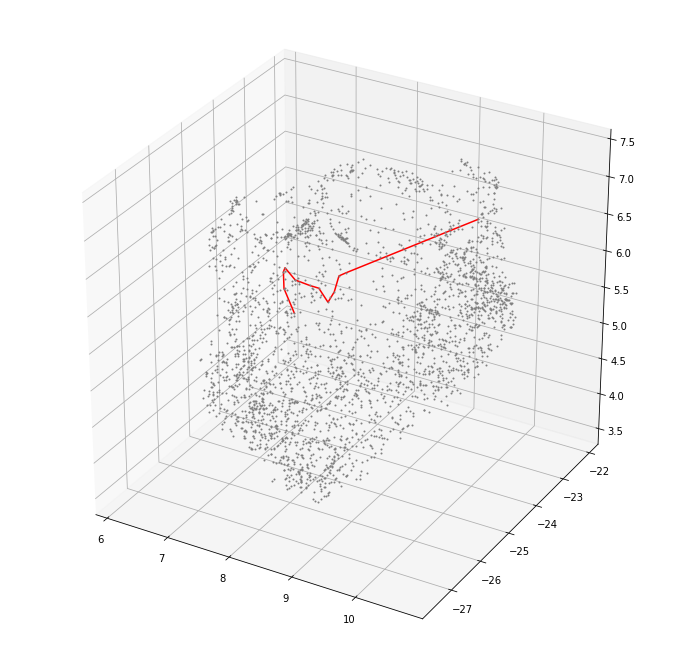

In [ ]:

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
 
#extract x and y coordinates from route list
x_coords = []
y_coords = []
z_coords = []
 
for i in range(len(path)):
  dream = result.iloc[path[i]]
  x = dream.x
  y = dream.y
  z = dream.z

  x_coords.append(x)
  y_coords.append(y)
  z_coords.append(z)

x_coords = np.array(x_coords)
y_coords = np.array(y_coords)
z_coords = np.array(z_coords)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter3D(goal[0],goal[1],goal[2], marker = "*", color = "red", s = 100)

for i in range(len(result.index)):
  d = result.iloc[i]
  ax.scatter3D(d.x,d.y,d.z,marker = "o", color = "grey", s = 1)


ax.plot3D(x_coords, y_coords, z_coords, color = "red")
plt.show()